# Explainable Timeseries

**Ziel**:
Einfluss einzelner Merkmalsausprägungen in kategorischer Zeitreihe auf Prädiktionsergebnis erklären.  

**Idee**:
Erhalte Einfluss durch entfernen des Wertes aus der Zeitreihe und Betrachtung der Differenz zur Vorhersage mit dem Wert.  

**Möglichkeiten**:  
- Gesamte Zeile entfernen (mit oder ohne Zurücklegen) -> nur korrekt, wenn einzige zeitabhängige Variable 
- Wert der kategorischen Größe durch anderen Tauschen  


**Erklärungen Notebook**:
- Beobachtet, dass sehr selten geklickt wird und es sehr viele unterschiedliche Brands gibt. Timeseries sehr unterschiedlich lange.
- Nehme Teilmenge, mit einer Zeitlänge von 11. 10 Werden encoded und 1 wird prädiziert. 
- SHAP und TFT lassen sich nicht kombinieren, da TFT nur auf TimeseriesDataset Objekten angewandt werden kann. 
- Schreibe daher Custom Methoden um die ausgedachte Logik zu implementieren.
- TimeseriesDataset kann schlecht manipuliert werden, gehe dafür Umweg über Pandas Dataframe und wandle geänderten Frame jedes Mal in TimeseriesDataset um und prädiziere dann darauf. 

- Wie haben andere Paper wie Shap oder Lime gebenchmarked?
- Wie kann ich statistische Evidenz dafür finden dass mein Ansatz mit marginaler Contribution sinnvoll ist?
- https://arxiv.org/pdf/2210.02176.pdf
- Statistisch gesehen, gibt es für eine Brand eine Häufung von Klicks? Macht es Sinn, dass die eine Brand bei mir eine hohe Contribution hat?
- Mehr Variablen reinnehmen
- Brands unter Threshold rausschmeißen, argumentieren, dass ich Mindestanzahl an Clicks mit Brand brauche


**TODOS:**
- MIt meiner leave-oneout Logik contributions rausfinden
- Mit seinem Script den vollen Shap Value der brand column erhalten
- Statistische Evidenz finden und Ergebnisse untermauern.

**Links**:
- https://stats.stackexchange.com/questions/598561/can-someone-explain-the-concept-of-shapley-value-masking-when-working-with-tabul
- https://docs.google.com/presentation/d/1vecqUIxKya1SGJuMyRAcKApDKmhBY9bR2BQMfvtVw9Y/edit#slide=id.p
- https://www.kaggle.com/code/alexthetiger1906/notebook7b313d54d2/edit
- https://www.kaggle.com/datasets/pavansanagapati/ad-displayclick-data-on-taobaocom?resource=download
- https://pytorch-forecasting.readthedocs.io/en/stable/tutorials/stallion.html
- https://www.depends-on-the-definition.com/shapley-values-from-scratch/
- https://christophm.github.io/interpretable-ml-book/feature-importance.html

In [27]:
import copy
from pathlib import Path
import warnings

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import numpy as np
import pandas as pd
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import MAE, SMAPE, PoissonLoss, QuantileLoss, CrossEntropy
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

In [28]:
df = pd.read_csv("data_small.csv")
df.dropna(inplace=True)
df['time_stamp'] = pd.to_datetime(df['time_stamp'], unit='s')
df.sort_values(by=['user', 'time_stamp'], inplace=True)
df['time_idx'] = df.groupby('user').cumcount()
df.rename(columns={"clk": "click"},inplace=True)

In [29]:
df

,user,age_level,brand,click,time_stamp,time_idx
593,117840,6,134255.0,0,2017-05-06 02:12:23,0
594,117840,6,437357.0,0,2017-05-06 02:12:23,1
904,286630,3,39443.0,0,2017-05-06 08:59:12,0
938,286630,3,234977.0,0,2017-05-06 09:01:19,1
939,286630,3,356908.0,0,2017-05-06 09:01:19,2
...,...,...,...,...,...,...
766,976358,3,188059.0,0,2017-05-08 06:20:21,13
776,976358,3,179491.0,0,2017-05-08 06:20:21,14
785,976358,3,188059.0,0,2017-05-08 06:20:21,15
765,976358,3,395046.0,0,2017-05-10 22:12:50,16


In [30]:
df.groupby('brand')['click'].mean()

brand
2505.0      0.0
2562.0      0.0
2999.0      0.0
3130.0      0.0
7713.0      0.0
           ... 
455924.0    0.0
456103.0    0.0
456647.0    0.0
457216.0    0.0
460162.0    0.0
Name: click, Length: 423, dtype: float64

In [31]:
#nicht jeder User clickt einmal
clk_sum_by_user = df.groupby('user')['click'].sum()
clk_sum_by_user

user
117840    0
286630    2
298139    1
399907    0
421590    2
555266    1
581738    4
623911    2
628137    0
739815    1
914836    1
976358    2
Name: click, dtype: int64

In [32]:
#die timeseries von unseren usern sind sehr unterschiedlich lang -> lies neuen dataframe ein, mit time_index = 10
df.groupby('user')['time_idx'].max()

user
117840      1
286630    133
298139    230
399907     13
421590     47
555266     13
581738    136
623911     75
628137      3
739815     12
914836     33
976358     17
Name: time_idx, dtype: int64

In [33]:
df = pd.read_csv("df_10.csv")
df.rename(columns={"clk": "click"},inplace=True)
df['age_level'] = df['age_level'].astype(str)
df['brand'] = df['brand'].astype(int).astype(str)
df['click'] = df['click'].astype(str)

df = df.iloc[:1000]

In [34]:
df

,user,age_level,brand,click,time_stamp,time_idx
0,43,5,138812,0,2017-05-07 16:49:44,0
1,43,5,6666,0,2017-05-07 17:22:13,1
2,43,5,364989,0,2017-05-07 17:22:13,2
3,43,5,138634,0,2017-05-07 19:25:47,3
4,43,5,374330,0,2017-05-07 19:25:47,4
...,...,...,...,...,...,...
995,4155,3,14133,0,2017-05-09 02:21:02,5
996,4155,3,228247,0,2017-05-10 03:09:18,6
997,4155,3,447105,0,2017-05-10 03:09:18,7
998,4155,3,337365,0,2017-05-12 03:29:41,8


In [35]:
len(df['brand'].unique())

724

In [36]:
max_prediction_length = 1
training_cutoff = df["time_idx"].max() - max_prediction_length
max_encoder_length = 10

In [37]:

training = TimeSeriesDataSet(
    df[lambda x: x.time_idx <= 10],
    time_idx="time_idx",
    target="click",
    group_ids=["user"],
    
    min_encoder_length=10,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=10,
    min_prediction_length=1,
    max_prediction_length=1,
    
    static_categoricals=["age_level"],
    time_varying_known_categoricals=["brand"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=["click"],

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
)

/Users/alexrothmaier/Desktop/Shap4TS/shapvenv/lib/python3.10/site-packages/pytorch_forecasting/data/timeseries.py:571: UserWarning: Target scales will be only added for continous targets
  warnings.warn("Target scales will be only added for continous targets", UserWarning)
/Users/alexrothmaier/Desktop/Shap4TS/shapvenv/lib/python3.10/site-packages/pytorch_forecasting/data/timeseries.py:1281: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 1 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__user': 4155}]
  warnings.warn(


In [38]:
# create validation set (predict=True) which means to predict the last max_prediction_length points in time
# for each series
validation = TimeSeriesDataSet.from_dataset(training, df, predict=True, stop_randomization=True)

# create dataloaders for model
batch_size = 16  # set this between 32 to 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size)

/Users/alexrothmaier/Desktop/Shap4TS/shapvenv/lib/python3.10/site-packages/pytorch_forecasting/data/timeseries.py:1281: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 1 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__user': 4155}]
  warnings.warn(


In [39]:
x, y = next(iter(val_dataloader))
print("x =", x)
print("\ny =", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

x = {'encoder_cat': tensor([[[  4,  65,   0],
         [  4, 668,   0],
         [  4, 449,   0],
         [  4,  64,   0],
         [  4, 464,   0],
         [  4,  65,   0],
         [  4, 556,   0],
         [  4, 576,   0],
         [  4, 101,   0],
         [  4, 101,   0]],

        [[  3, 616,   0],
         [  3, 222,   0],
         [  3, 337,   0],
         [  3, 616,   0],
         [  3, 698,   0],
         [  3, 222,   0],
         [  3, 268,   0],
         [  3, 222,   0],
         [  3, 337,   0],
         [  3, 192,   0]],

        [[  4, 304,   0],
         [  4, 463,   0],
         [  4, 456,   0],
         [  4, 304,   0],
         [  4, 437,   0],
         [  4, 171,   0],
         [  4, 470,   0],
         [  4, 720,   0],
         [  4, 657,   0],
         [  4, 388,   0]],

        [[  3, 422,   0],
         [  3, 498,   0],
         [  3, 119,   0],
         [  3, 108,   0],
         [  3, 547,   0],
         [  3, 185,   0],
         [  3, 532,   0],
         [  

In [40]:
len(val_dataloader)

6

In [41]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=8,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=8,  # set to <= hidden_size
    
    
    #TODO: Loss ändern
    loss=CrossEntropy(),
    optimizer="Ranger"
    # reduce learning rate if no improvement in validation loss after x epochs
    # reduce_on_plateau_patience=1000,
)

/Users/alexrothmaier/Desktop/Shap4TS/shapvenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  rank_zero_warn(
/Users/alexrothmaier/Desktop/Shap4TS/shapvenv/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:197: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  rank_zero_warn(


In [42]:
import lightning.pytorch as pl


In [43]:
# configure network and trainer
pl.seed_everything(42)
trainer = pl.Trainer(
    accelerator="cpu",
    # clipping gradients is a hyperparameter and important to prevent divergance
    # of the gradient for recurrent neural networks
    gradient_clip_val=0.1,
    max_epochs=50
)

Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [44]:
# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | CrossEntropy                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 5.8 K 
3  | prescalers                         | ModuleDict                      | 48    
4  | static_variable_selection          | VariableSelectionNetwork        | 398   
5  | encoder_variable_selection         | VariableSelectionNetwork        | 904   
6  | decoder_variable_selection         | VariableSelectionNetwork        | 814   
7  | static_context_variable_selection  | GatedResidualNetwork            | 304   
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 304   
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 304 

Sanity Checking DataLoader 0:   0%|                       | 0/2 [00:00<?, ?it/s]

/Users/alexrothmaier/Desktop/Shap4TS/shapvenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


/Users/alexrothmaier/Desktop/Shap4TS/shapvenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/alexrothmaier/Desktop/Shap4TS/shapvenv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (5) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|██| 5/5 [00:00<00:00, 26.43it/s, v_num=554, train_loss_step=0.502]
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:00, 50.21it/s]
Epoch 0: 100%|█| 5/5 [00:00<00:00, 15.11it/s, v_num=554, train_loss_step=0.502, 
Epoch 1: 100%|█| 5/5 [00:00<00:00, 29.76it/s, v_num=554, train_loss_step=0.370, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:00, 50.35it/s]
Epoch 1: 100%|█| 5/5 [00:00<00:00, 16.18it/s, v_num=554, train_loss_step=0.370, 
Epoch 2: 100%|█| 5/5 [00:00<00:00, 31.35it/s, v_num=554, train_loss_step=0.322, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:00, 51.51it/s]
Epoch 2: 100%|█| 5/5 [00:00<00:00, 16.65it/s, v_num=554, train_loss_step=0.322, 
Epoch 3: 100%|█| 5/5 [00:00<00:00, 31.03it/s, v_num=554, train_loss_step=0.310, 
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:

Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:00, 55.45it/s]
Epoch 10: 100%|█| 5/5 [00:00<00:00, 17.57it/s, v_num=554, train_loss_step=0.0434
Epoch 11: 100%|█| 5/5 [00:00<00:00, 32.22it/s, v_num=554, train_loss_step=0.242,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:00, 56.85it/s]
Epoch 11: 100%|█| 5/5 [00:00<00:00, 17.71it/s, v_num=554, train_loss_step=0.242,
Epoch 12: 100%|█| 5/5 [00:00<00:00, 30.84it/s, v_num=554, train_loss_step=0.0334
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:00, 53.11it/s]
Epoch 12: 100%|█| 5/5 [00:00<00:00, 16.88it/s, v_num=554, train_loss_step=0.0334
Epoch 13: 100%|█| 5/5 [00:00<00:00, 30.60it/s, v_num=554, train_loss_step=0.0345
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:00, 58.87it/s]
Epoch 13: 100%|█| 5/5 [00:00<00:00, 17.48it/s, v_num=554, train_loss_step=0.0345
Epoch 14: 100%|█

Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:00, 52.16it/s]
Epoch 20: 100%|█| 5/5 [00:00<00:00, 16.39it/s, v_num=554, train_loss_step=0.016,
Epoch 21: 100%|█| 5/5 [00:00<00:00, 30.94it/s, v_num=554, train_loss_step=0.0188
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:00, 54.90it/s]
Epoch 21: 100%|█| 5/5 [00:00<00:00, 17.00it/s, v_num=554, train_loss_step=0.0188
Epoch 22: 100%|█| 5/5 [00:00<00:00, 32.84it/s, v_num=554, train_loss_step=0.014,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:00, 59.86it/s]
Epoch 22: 100%|█| 5/5 [00:00<00:00, 18.21it/s, v_num=554, train_loss_step=0.014,
Epoch 23: 100%|█| 5/5 [00:00<00:00, 30.93it/s, v_num=554, train_loss_step=0.0132
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:00, 56.05it/s]
Epoch 23: 100%|█| 5/5 [00:00<00:00, 17.11it/s, v_num=554, train_loss_step=0.0132
Epoch 24: 100%|█

Epoch 31: 100%|█| 5/5 [00:00<00:00, 30.26it/s, v_num=554, train_loss_step=0.277,
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:00, 59.68it/s]
Epoch 31: 100%|█| 5/5 [00:00<00:00, 17.34it/s, v_num=554, train_loss_step=0.277,
Epoch 32: 100%|█| 5/5 [00:00<00:00, 32.23it/s, v_num=554, train_loss_step=0.0049
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:00, 59.74it/s]
Epoch 32: 100%|█| 5/5 [00:00<00:00, 18.06it/s, v_num=554, train_loss_step=0.0049
Epoch 33: 100%|█| 5/5 [00:00<00:00, 31.64it/s, v_num=554, train_loss_step=0.0050
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:00, 56.87it/s]
Epoch 33: 100%|█| 5/5 [00:00<00:00, 17.50it/s, v_num=554, train_loss_step=0.0050
Epoch 34: 100%|█| 5/5 [00:00<00:00, 32.79it/s, v_num=554, train_loss_step=0.0040
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:

Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:00, 57.69it/s]
Epoch 41: 100%|█| 5/5 [00:00<00:00, 17.29it/s, v_num=554, train_loss_step=0.0012
Epoch 42: 100%|█| 5/5 [00:00<00:00, 28.07it/s, v_num=554, train_loss_step=0.0011
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:00, 59.63it/s]
Epoch 42: 100%|█| 5/5 [00:00<00:00, 16.69it/s, v_num=554, train_loss_step=0.0011
Epoch 43: 100%|█| 5/5 [00:00<00:00, 32.67it/s, v_num=554, train_loss_step=0.0021
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:00, 57.72it/s]
Epoch 43: 100%|█| 5/5 [00:00<00:00, 17.91it/s, v_num=554, train_loss_step=0.0021
Epoch 44: 100%|█| 5/5 [00:00<00:00, 32.29it/s, v_num=554, train_loss_step=0.0008
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  83%|████████████████▋   | 5/6 [00:00<00:00, 51.89it/s]
Epoch 44: 100%|█| 5/5 [00:00<00:00, 17.20it/s, v_num=554, train_loss_step=0.0008
Epoch 45: 100%|█

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|█| 5/5 [00:00<00:00, 15.58it/s, v_num=554, train_loss_step=0.0019


In [45]:
raw_predictions = tft.predict(val_dataloader,mode='raw',return_x=True)

/Users/alexrothmaier/Desktop/Shap4TS/shapvenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [46]:
raw_predictions.keys()

('output', 'x', 'index', 'decoder_lengths', 'y')

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x250 with 1 Axes>,
 'encoder_variables': <Figure size 700x300 with 1 Axes>,
 'decoder_variables': <Figure size 700x275 with 1 Axes>}

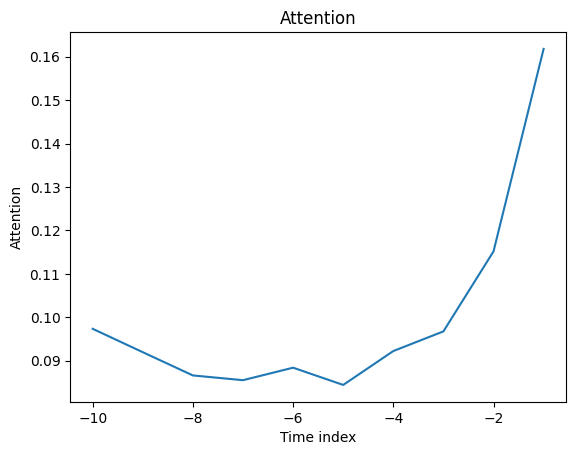

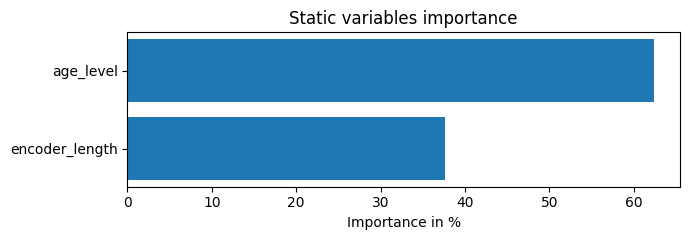

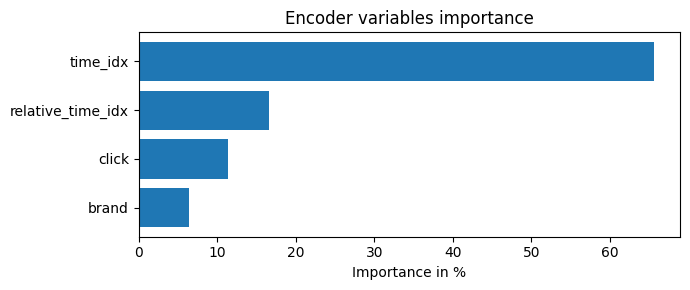

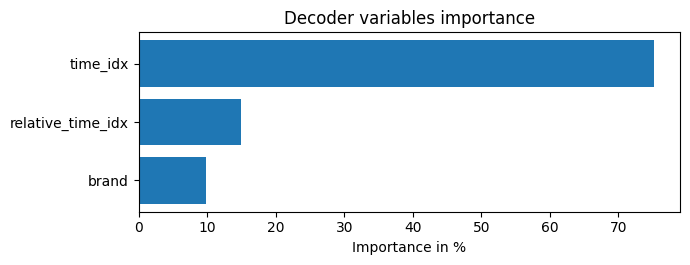

In [47]:
interpretation = tft.interpret_output(raw_predictions.output, reduction="sum")
tft.plot_interpretation(interpretation)

In [48]:
predictions_43 = tft.predict(training.filter(lambda x: x.user==43),return_y=True)

/Users/alexrothmaier/Desktop/Shap4TS/shapvenv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


In [49]:
predictions_43

Prediction(output=tensor([[0]]), x=None, index=None, decoder_lengths=None, y=(tensor([[0]]), None))

In [50]:
predictions = tft.predict(val_dataloader,return_y=True)

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 16 but got size 10 for tensor number 5 in the list.

In [362]:
len(val_dataloader)

90

In [363]:
len(predictions.y[0].flatten().tolist())

90

In [644]:
for out,y,idx in zip(predictions.output.flatten().tolist(),predictions.y[0].flatten().tolist(),range(0,len(predictions.y[0].flatten().tolist()))):
    if y==1:
        print(idx, out,y)

8 -0.024677887558937073 1
55 -0.02497069537639618 1
68 -0.023364707827568054 1


Wieso werden bei manchen negativen Werten 1en prädiziert und bei anderen die noch negativer sind trotzdem eine 0?

In [416]:
#Do NOT delete!
baseline = Baseline()
def masker(mask,x):
    return x
explainer = shap.Explainer(baseline.predict, masker=masker)  # Pass `baseline` as the model and the custom masker

# Compute the SHAP values for each batch in the DataLoader
shap_values = []
for batch in val_dataloader:
    x = batch[0]["encoder_cat"], batch[0]["encoder_cont"]
    shap_values_batch = explainer(x)
    shap_values.append(shap_values_batch)

# Concatenate the SHAP values into a single tensor
shap_values_tensor = torch.cat(shap_values, dim=0)

AttributeError: 'numpy.ndarray' object has no attribute 'dataset'

## Selbstversuch

SHAP und TimeSeriesDataSet scheinbar nicht kompatibel... 

Idee: nehme das Inferenz Sample, wähle Spalte j und maskiere nacheinander alle Werte aus, berechne die neuen predictions und speichere in einem Dictionary  

**Erkenntnisse**  
- SHAP und TimeSeriesDataSet klappt miteinander nicht
- Einzelne Samples können der predict Methode von tft nicht übergeben werden, nur TimeSeriesDataset oder Loader davon

In [21]:
sample = next(iter(val_dataloader))

In [22]:
sample

({'encoder_cat': tensor([[[  4,  65,   0],
           [  4, 668,   0],
           [  4, 449,   0],
           [  4,  64,   0],
           [  4, 464,   0],
           [  4,  65,   0],
           [  4, 556,   0],
           [  4, 576,   0],
           [  4, 101,   0],
           [  4, 101,   0]],
  
          [[  3, 616,   0],
           [  3, 222,   0],
           [  3, 337,   0],
           [  3, 616,   0],
           [  3, 698,   0],
           [  3, 222,   0],
           [  3, 268,   0],
           [  3, 222,   0],
           [  3, 337,   0],
           [  3, 192,   0]],
  
          [[  4, 304,   0],
           [  4, 463,   0],
           [  4, 456,   0],
           [  4, 304,   0],
           [  4, 437,   0],
           [  4, 171,   0],
           [  4, 470,   0],
           [  4, 720,   0],
           [  4, 657,   0],
           [  4, 388,   0]],
  
          [[  3, 422,   0],
           [  3, 498,   0],
           [  3, 119,   0],
           [  3, 108,   0],
           [  3, 547,

In [51]:
user_43 = df[df['user']==43]
user_43.drop(index=[],inplace=True)
user_43

/var/folders/m6/4_p41bcx58jddx_zhmmqd_v00000gn/T/ipykernel_5147/3780534846.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_43.drop(index=[],inplace=True)


,user,age_level,brand,click,time_stamp,time_idx
0,43,5,138812,0,2017-05-07 16:49:44,0
1,43,5,6666,0,2017-05-07 17:22:13,1
2,43,5,364989,0,2017-05-07 17:22:13,2
3,43,5,138634,0,2017-05-07 19:25:47,3
4,43,5,374330,0,2017-05-07 19:25:47,4
5,43,5,138812,0,2017-05-07 19:25:47,5
6,43,5,413526,0,2017-05-07 23:27:56,6
7,43,5,422876,0,2017-05-07 23:27:56,7
8,43,5,16008,0,2017-05-08 02:34:02,8
9,43,5,16008,0,2017-05-08 02:34:02,9


In [52]:
det 

NameError: name 'det' is not defined

In [53]:

data_43 = TimeSeriesDataSet(
    user_43[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="click",
    group_ids=["user"],
    
    min_encoder_length=10,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=10,
    min_prediction_length=1,
    max_prediction_length=1,
    
    static_categoricals=["age_level"],
    time_varying_known_categoricals=["brand"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=["click"],

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
    allow_missing_timesteps=True
)
loader = data_43.to_dataloader()

/Users/alexrothmaier/Desktop/Shap4TS/shapvenv/lib/python3.10/site-packages/pytorch_forecasting/data/timeseries.py:571: UserWarning: Target scales will be only added for continous targets
  warnings.warn("Target scales will be only added for continous targets", UserWarning)
/Users/alexrothmaier/Desktop/Shap4TS/shapvenv/lib/python3.10/site-packages/pytorch_forecasting/data/timeseries.py:1281: UserWarning: Min encoder length and/or min_prediction_idx and/or min prediction length and/or lags are too large for 1 series/groups which therefore are not present in the dataset index. This means no predictions can be made for those series. First 10 removed groups: [{'__group_id__user': 43}]
  warnings.warn(


AssertionError: filters should not remove entries all entries - check encoder/decoder lengths and lags

In [505]:
data_43.data

{'reals': tensor([[ 0.0000, -1.5811,  0.0000],
         [ 0.0000, -1.2649,  0.0000],
         [ 0.0000, -0.9487,  0.0000],
         [ 0.0000, -0.6325,  0.0000],
         [ 0.0000, -0.3162,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.3162,  0.0000],
         [ 0.0000,  0.6325,  0.0000],
         [ 0.0000,  0.9487,  0.0000],
         [ 0.0000,  1.2649,  0.0000],
         [ 0.0000,  1.5811,  0.0000]]),
 'categoricals': tensor([[0, 1, 0],
         [0, 8, 0],
         [0, 3, 0],
         [0, 0, 0],
         [0, 4, 0],
         [0, 1, 0],
         [0, 6, 0],
         [0, 7, 0],
         [0, 2, 0],
         [0, 2, 0],
         [0, 5, 0]]),
 'groups': tensor([[0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0],
         [0]]),
 'target': [tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])],
 'weight': None,
 'time': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])}

In [506]:
x, y = next(iter(loader))
print("x =", x)
print("\ny =", y)
print("\nsizes of x =")
for key, value in x.items():
    print(f"\t{key} = {value.size()}")

x = {'encoder_cat': tensor([[[0, 1, 0],
         [0, 8, 0],
         [0, 3, 0],
         [0, 0, 0],
         [0, 4, 0],
         [0, 1, 0],
         [0, 6, 0],
         [0, 7, 0],
         [0, 2, 0],
         [0, 2, 0]]]), 'encoder_cont': tensor([[[ 1.0000, -1.5811, -1.0000],
         [ 1.0000, -1.2649, -0.9000],
         [ 1.0000, -0.9487, -0.8000],
         [ 1.0000, -0.6325, -0.7000],
         [ 1.0000, -0.3162, -0.6000],
         [ 1.0000,  0.0000, -0.5000],
         [ 1.0000,  0.3162, -0.4000],
         [ 1.0000,  0.6325, -0.3000],
         [ 1.0000,  0.9487, -0.2000],
         [ 1.0000,  1.2649, -0.1000]]]), 'encoder_target': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'encoder_lengths': tensor([10]), 'decoder_cat': tensor([[[0, 5, 0]]]), 'decoder_cont': tensor([[[1.0000, 1.5811, 0.0000]]]), 'decoder_target': tensor([[0]]), 'decoder_lengths': tensor([1]), 'decoder_time_idx': tensor([[10]]), 'groups': tensor([[0]]), 'target_scale': tensor([[0., 0.]])}

y = (tensor([[0]]), None)

siz

In [507]:
preds_43 = tft.predict(data_43)
preds_43

tensor([[-0.0262]])

In [65]:
def get_tsds(df):
    return TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="click",
    group_ids=["user"],
    
    min_encoder_length=9,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=10,
    min_prediction_length=1,
    max_prediction_length=1,
    
    static_categoricals=["age_level"],
    time_varying_known_categoricals=["brand"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=["click"],

    add_relative_time_idx=True,
    add_target_scales=True,
    add_encoder_length=True,
    
    allow_missing_timesteps=True,
    #predict_mode=True
)

# Komplette Zeile entfernen

### Sukzessives Wegnehmen ohne Zurücklegen

Es werden Schritt für Schritt die Zeilen komplett entfernt. Die letzte und 1. muss dabei bleiben

In [59]:
import warnings
warnings.filterwarnings('ignore')

In [60]:
df[df['user']==43]

,user,age_level,brand,click,time_stamp,time_idx
0,43,5,138812,0,2017-05-07 16:49:44,0
1,43,5,6666,0,2017-05-07 17:22:13,1
2,43,5,364989,0,2017-05-07 17:22:13,2
3,43,5,138634,0,2017-05-07 19:25:47,3
4,43,5,374330,0,2017-05-07 19:25:47,4
5,43,5,138812,0,2017-05-07 19:25:47,5
6,43,5,413526,0,2017-05-07 23:27:56,6
7,43,5,422876,0,2017-05-07 23:27:56,7
8,43,5,16008,0,2017-05-08 02:34:02,8
9,43,5,16008,0,2017-05-08 02:34:02,9


In [61]:
#Achtung: letzte Reihe muss bleiben zum prädizieren
user_43 = df[df['user']==43]
referenz = tft.predict(get_tsds(user_43))
feature_values_list = []
values_list = []
print(f"Mit allen Datenpunkten ist die Prediction: {round(referenz.item(),4)}")
for i in range(len(user_43)-2,0,-1):
    brand = user_43.iloc[i].brand
    user_43.drop(index=i,inplace=True)
    tsds = get_tsds(user_43)
    pred = tft.predict(tsds)
    diff = round((referenz-pred).item(),4)
    print(f"Lasse {brand} weg und erhalte als Prediction {round(pred.item(),4)}, das sind {diff} Differenz")
    
    feature_values_list.append(brand)
    values_list.append(diff)

Mit allen Datenpunkten ist die Prediction: 0
Lasse 16008 weg und erhalte als Prediction 0, das sind 0 Differenz
Lasse 16008 weg und erhalte als Prediction 0, das sind 0 Differenz
Lasse 422876 weg und erhalte als Prediction 0, das sind 0 Differenz
Lasse 413526 weg und erhalte als Prediction 0, das sind 0 Differenz
Lasse 138812 weg und erhalte als Prediction 0, das sind 0 Differenz
Lasse 374330 weg und erhalte als Prediction 0, das sind 0 Differenz
Lasse 138634 weg und erhalte als Prediction 0, das sind 0 Differenz
Lasse 364989 weg und erhalte als Prediction 0, das sind 0 Differenz


AssertionError: filters should not remove entries all entries - check encoder/decoder lengths and lags

In [649]:
user_43

,user,age_level,brand,click,time_stamp,time_idx
0,43,5,138812,0,2017-05-07 16:49:44,0
10,43,5,405681,0,2017-05-08 02:34:02,10


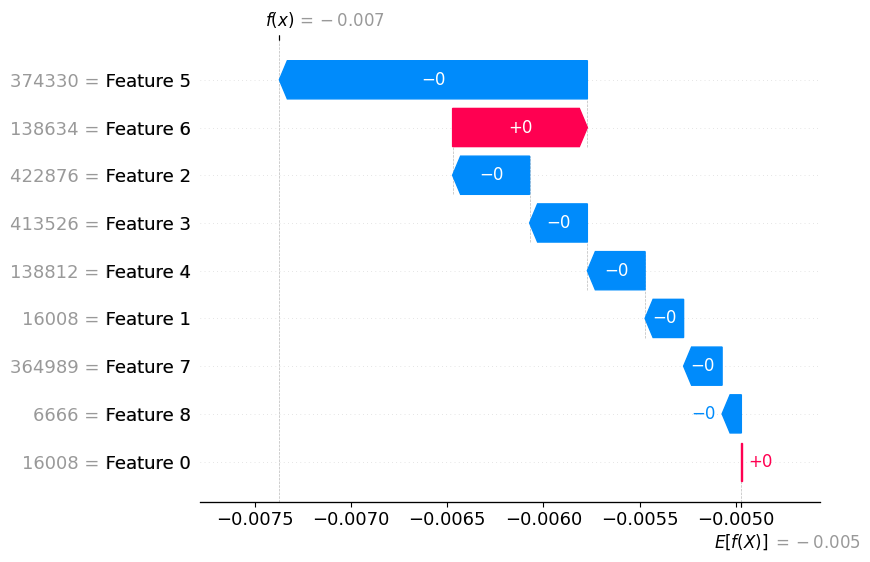

In [679]:
import shap
import numpy as np

# Example feature values
feature_values = np.array(feature_values_list)


# Example SHAP values
shap_values = np.array(values_list)

# Create a SHAP Explanation object
expl = shap.Explanation(values=shap_values, base_values=referenz.item(), data=feature_values)

# Plot the waterfall chart
shap.plots.waterfall(expl)

### Sukzessives Wegnehmen mit Zurücklegen

Es werden Schritt für Schritt die Zeilen komplett entfernt. Die letzte und 1. muss dabei bleiben

In [650]:
df[df['user']==43]

,user,age_level,brand,click,time_stamp,time_idx
0,43,5,138812,0,2017-05-07 16:49:44,0
1,43,5,6666,0,2017-05-07 17:22:13,1
2,43,5,364989,0,2017-05-07 17:22:13,2
3,43,5,138634,0,2017-05-07 19:25:47,3
4,43,5,374330,0,2017-05-07 19:25:47,4
5,43,5,138812,0,2017-05-07 19:25:47,5
6,43,5,413526,0,2017-05-07 23:27:56,6
7,43,5,422876,0,2017-05-07 23:27:56,7
8,43,5,16008,0,2017-05-08 02:34:02,8
9,43,5,16008,0,2017-05-08 02:34:02,9


In [66]:
#Achtung: letzte Reihe muss bleiben zum prädizieren
user_43 = df[df['user']==43]
referenz = tft.predict(get_tsds(user_43))
print(f"Mit allen Datenpunkten ist die Prediction: {round(referenz.item(),4)}")
for i in range(len(user_43)-2,0,-1):
    brand = user_43.iloc[i].brand
    my_df = user_43.drop(index=i)
    tsds = get_tsds(my_df)
    pred = tft.predict(tsds)
    print(f"Lasse {brand} weg und erhalte als Prediction {round(pred.item(),4)}, das sind {round((referenz-pred).item(),4)} Differenz")
    
    

Mit allen Datenpunkten ist die Prediction: 0


AssertionError: filters should not remove entries all entries - check encoder/decoder lengths and lags

In [555]:
user_43

,user,age_level,brand,click,time_stamp,time_idx
0,43,5,138812,0,2017-05-07 16:49:44,0
1,43,5,6666,0,2017-05-07 17:22:13,1
2,43,5,364989,0,2017-05-07 17:22:13,2
3,43,5,138634,0,2017-05-07 19:25:47,3
4,43,5,374330,0,2017-05-07 19:25:47,4
5,43,5,138812,0,2017-05-07 19:25:47,5
6,43,5,413526,0,2017-05-07 23:27:56,6
7,43,5,422876,0,2017-05-07 23:27:56,7
8,43,5,16008,0,2017-05-08 02:34:02,8
9,43,5,16008,0,2017-05-08 02:34:02,9


# Nur Brand entfernen

In [620]:
user_43 = df[df['user']==43]
df

,user,age_level,brand,click,time_stamp,time_idx
0,43,5,138812,0,2017-05-07 16:49:44,0
1,43,5,6666,0,2017-05-07 17:22:13,1
2,43,5,364989,0,2017-05-07 17:22:13,2
3,43,5,138634,0,2017-05-07 19:25:47,3
4,43,5,374330,0,2017-05-07 19:25:47,4
...,...,...,...,...,...,...
995,4155,3,14133,0,2017-05-09 02:21:02,5
996,4155,3,228247,0,2017-05-10 03:09:18,6
997,4155,3,447105,0,2017-05-10 03:09:18,7
998,4155,3,337365,0,2017-05-12 03:29:41,8


In [67]:
user_43 = df[df['user']==43]
referenz = tft.predict(get_tsds(user_43))

# Letzte Zeile darf nicht ersetzt werden 
for index, row in user_43[:-1].iterrows():
    
    # Setze Brand auf anderen Wert
    buffer = user_43.loc[index, 'brand']
    #print(type(buffer))
    user_43.loc[index, 'brand'] = 'NaN'
    
    tsds = get_tsds(user_43)
    pred = tft.predict(tsds)
    
    #print(user_43)
    # Setze auf ursprünglichen Wert zurück
    user_43.loc[index, 'brand'] = buffer
    
    print(f"Lasse {buffer} weg und erhalte als Prediction {round(pred.item(),4)}, das sind {round((referenz-pred).item(),4)} Differenz")

    
    

Lasse 138812 weg und erhalte als Prediction 0, das sind 0 Differenz
Lasse 6666 weg und erhalte als Prediction 0, das sind 0 Differenz
Lasse 364989 weg und erhalte als Prediction 0, das sind 0 Differenz
Lasse 138634 weg und erhalte als Prediction 0, das sind 0 Differenz
Lasse 374330 weg und erhalte als Prediction 0, das sind 0 Differenz
Lasse 138812 weg und erhalte als Prediction 0, das sind 0 Differenz
Lasse 413526 weg und erhalte als Prediction 0, das sind 0 Differenz
Lasse 422876 weg und erhalte als Prediction 0, das sind 0 Differenz
Lasse 16008 weg und erhalte als Prediction 0, das sind 0 Differenz
Lasse 16008 weg und erhalte als Prediction 0, das sind 0 Differenz


In [593]:
user_43

,user,age_level,brand,click,time_stamp,time_idx
0,43,5,20,0,2017-05-07 16:49:44,0
1,43,5,20,0,2017-05-07 17:22:13,1
2,43,5,20,0,2017-05-07 17:22:13,2
3,43,5,20,0,2017-05-07 19:25:47,3
4,43,5,20,0,2017-05-07 19:25:47,4
5,43,5,20,0,2017-05-07 19:25:47,5
6,43,5,20,0,2017-05-07 23:27:56,6
7,43,5,20,0,2017-05-07 23:27:56,7
8,43,5,20,0,2017-05-08 02:34:02,8
9,43,5,20,0,2017-05-08 02:34:02,9


- Ergebnisse durch deskr. Statistik validieren. -> Reduziere Anzahl von Brand und betrachte durchschn. click rate
- Shap verwenden durch custom wrapper mit predict_proba etc. umschreiben dass es auch für numpy geht und kompatibel mit shap library ist
- für jeden Zeitschritt einzeln SHAP Value berechnen (alle 10, dann 9, dann 8)
- loss funktion in classification loss statt regression loss abändern
- ohne zurücklegen
- KernelExplainer verwenden





In [62]:
import shap
explainer = shap.Explainer(tft)

In [65]:
explainer(training)

AttributeError: 'tuple' object has no attribute 'shape'

In [68]:
df_43 = df[df['user']==43]
df_43

,user,age_level,brand,click,time_stamp,time_idx
0,43,5,138812,0,2017-05-07 16:49:44,0
1,43,5,6666,0,2017-05-07 17:22:13,1
2,43,5,364989,0,2017-05-07 17:22:13,2
3,43,5,138634,0,2017-05-07 19:25:47,3
4,43,5,374330,0,2017-05-07 19:25:47,4
5,43,5,138812,0,2017-05-07 19:25:47,5
6,43,5,413526,0,2017-05-07 23:27:56,6
7,43,5,422876,0,2017-05-07 23:27:56,7
8,43,5,16008,0,2017-05-08 02:34:02,8
9,43,5,16008,0,2017-05-08 02:34:02,9


In [ ]:
explainer = shap.KernelExplainer()

In [232]:
def get_tsds(df):
    return TimeSeriesDataSet(
    df[lambda x: x.time_idx <= training_cutoff],
    time_idx="time_idx",
    target="click",
    group_ids=["user"],
    
    min_encoder_length=0,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=10,
    min_prediction_length=1,
    max_prediction_length=1,
    
    static_categoricals=["age_level"],
    time_varying_known_categoricals=["brand"],
    time_varying_known_reals=["time_idx"],
    time_varying_unknown_categoricals=["click"],

    add_relative_time_idx=True,
    add_target_scales=False,
    add_encoder_length=True,
    
    allow_missing_timesteps=True,
        
    predict_mode=True
)

In [239]:
class Custom_TFT():
    
    def __init__(self,tft,df):
        self.tft = tft
        self.columns = df.columns
        self.dtypes = df.dtypes
    
    def fit(self):
        pass
    
    
    def predict(self, X_arr) -> np.ndarray:
        
        #print(type(df))
        #print(df)
        df = pd.DataFrame(X_arr,columns=self.columns).astype(self.dtypes)
        print("***NEW CALL**")
        print(df)
        tsds = get_tsds(df)
        
        
        
        preds = tft.predict(tsds, mode="raw", return_x=False).prediction.flatten().numpy()
        #TODO: überführe preds in ein numpy array
        return np.array([3,2,3,3,3,3])
    
    def predict_proba(self, df) -> np.ndarray:
        #TODO: checke ob probabilities übereinstimmen mit prediction!
        tsds = get_tsds(df)
        probabilities = Softmax(dim=2)(tft.predict(tsds, mode="raw", return_x=False).prediction).flatten().numpy()
        return probabilities
    
    
    
    

In [240]:
my_tft = Custom_TFT(tft,df_43)

In [241]:
df_43

,user,age_level,brand,click,time_stamp,time_idx
0,43,5,138812,0,2017-05-07 16:49:44,0
1,43,5,6666,0,2017-05-07 17:22:13,1
2,43,5,364989,0,2017-05-07 17:22:13,2
3,43,5,138634,0,2017-05-07 19:25:47,3
4,43,5,374330,0,2017-05-07 19:25:47,4
5,43,5,138812,0,2017-05-07 19:25:47,5
6,43,5,413526,0,2017-05-07 23:27:56,6
7,43,5,422876,0,2017-05-07 23:27:56,7
8,43,5,16008,0,2017-05-08 02:34:02,8
9,43,5,16008,0,2017-05-08 02:34:02,9


In [242]:
df_43.to_numpy()

array([[43, '5', '138812', '0', '2017-05-07 16:49:44', 0],
       [43, '5', '6666', '0', '2017-05-07 17:22:13', 1],
       [43, '5', '364989', '0', '2017-05-07 17:22:13', 2],
       [43, '5', '138634', '0', '2017-05-07 19:25:47', 3],
       [43, '5', '374330', '0', '2017-05-07 19:25:47', 4],
       [43, '5', '138812', '0', '2017-05-07 19:25:47', 5],
       [43, '5', '413526', '0', '2017-05-07 23:27:56', 6],
       [43, '5', '422876', '0', '2017-05-07 23:27:56', 7],
       [43, '5', '16008', '0', '2017-05-08 02:34:02', 8],
       [43, '5', '16008', '0', '2017-05-08 02:34:02', 9],
       [43, '5', '405681', '0', '2017-05-08 02:34:02', 10]], dtype=object)

In [245]:
def custom_masker(data):
    # Specify the columns of interest
    columns_of_interest = ['age_level', 'brand']

    # Create a masked version of the data DataFrame with only the columns of interest
    masked_data = data[columns_of_interest]

    return masked_data

In [246]:
explainer = shap.KernelExplainer(model=my_tft.predict,data=df_43.loc[:5],masker=custom_masker)

***NEW CALL**
   user age_level   brand click           time_stamp  time_idx
0    43         5  138812     0  2017-05-07 16:49:44         0
1    43         5    6666     0  2017-05-07 17:22:13         1
2    43         5  364989     0  2017-05-07 17:22:13         2
3    43         5  138634     0  2017-05-07 19:25:47         3
4    43         5  374330     0  2017-05-07 19:25:47         4
5    43         5  138812     0  2017-05-07 19:25:47         5


The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


- shap macht komische Dinge mit time_stamp column -> maskieren
- shap möchte nicht nur eine prediction zurückbekommen, sondern für jede Zeile eine. 

In [250]:
from omnixai.data.timeseries import Timeseries
from omnixai.explainers.timeseries import ShapTimeseries


ModuleNotFoundError: No module named 'omnixai'

In [249]:
explainer.shap_values(df_43.loc[5],masker=custom_masker)

***NEW CALL**
   user age_level   brand click           time_stamp  time_idx
0    43         5  138812     0  2017-05-07 19:25:47         5
***NEW CALL**
    user age_level   brand click           time_stamp  time_idx
0     43         5  138812     0  2017-05-07 16:49:44         0
1     43         5  138812     0  2017-05-07 17:22:13         1
2     43         5  138812     0  2017-05-07 17:22:13         2
3     43         5  138812     0  2017-05-07 19:25:47         3
4     43         5  138812     0  2017-05-07 19:25:47         4
5     43         5  138812     0  2017-05-07 19:25:47         5
6     43         5  138812     0  2017-05-07 19:25:47         5
7     43         5    6666     0  2017-05-07 19:25:47         5
8     43         5  364989     0  2017-05-07 19:25:47         5
9     43         5  138634     0  2017-05-07 19:25:47         5
10    43         5  374330     0  2017-05-07 19:25:47         5
11    43         5  138812     0  2017-05-07 19:25:47         5
12    43      

The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.


ValueError: cannot reshape array of size 6 into shape (36,1)

In [221]:
explainer(df_43)

AttributeError: 'Kernel' object has no attribute 'masker'